<a href="https://colab.research.google.com/github/pedroheyerdahl/cbers04a/blob/main/rasterio_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with CBERS 04A Images with Rasterio on Google Colab
This notebook is inspired by the tutorial found at https://towardsdatascience.com/access-satellite-imagery-with-aws-and-google-colab-4660178444f5 adapted as a first draft for working with computer vision tasks over cbers 04A data imported from google drive

Installing rasterio on the notebook

In [1]:
!pip install rasterio


Importing the libraries we are going to use. Our primary tool is Rasterio which provides an easy to use API for processing satellite imagery

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from itertools import product
from rasterio import windows
from rasterio.plot import show


Mounting google drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Opening an image using rasterio

In [4]:
sample_image = rio.open('/content/drive/MyDrive/CBERS04A/sample_image.tif')
sample_label = rio.open('/content/drive/MyDrive/CBERS04A/sample_label.tif')

Plotting loaded image with matplotlib

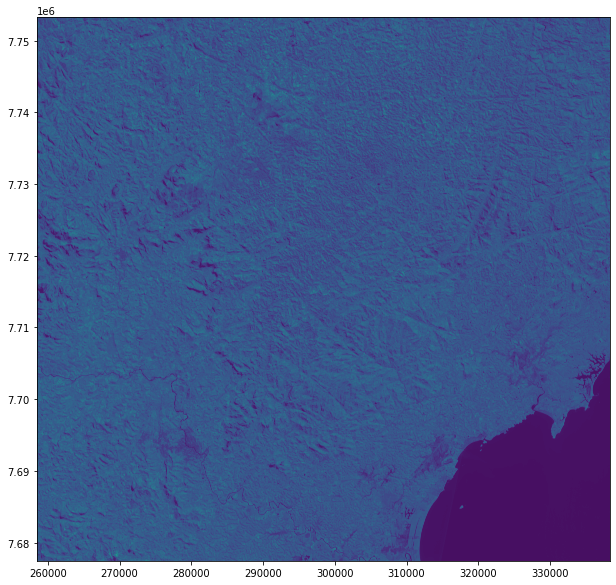

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(sample_image, ax=ax)
plt.show()

Plotting sample labels with matplotlib

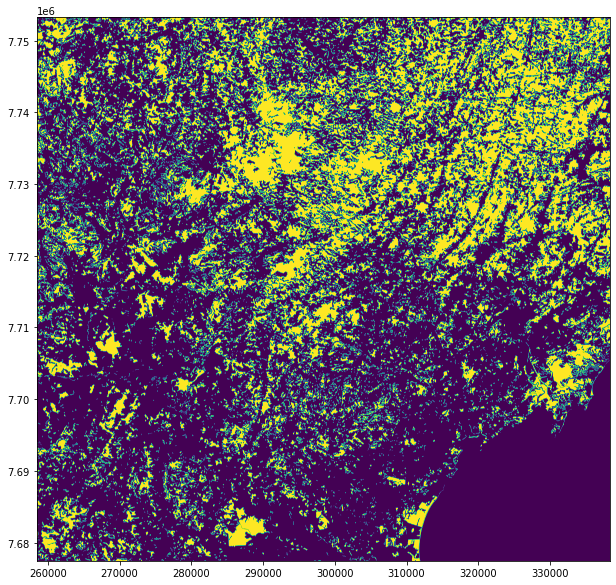

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(sample_label, ax=ax)
plt.show()

Checking if image and label have same metadata

In [7]:
print(sample_image.meta)
print(sample_label.meta)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 9984, 'height': 9472, 'count': 3, 'crs': CRS.from_epsg(31984), 'transform': Affine(8.0, 0.0, 258428.0,
       0.0, -8.0, 7753250.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 9984, 'height': 9472, 'count': 1, 'crs': CRS.from_epsg(31984), 'transform': Affine(8.0, 0.0, 258428.0,
       0.0, -8.0, 7753250.0)}


Converting the image to numpy arrays

In [8]:
src_image_array = sample_image.read(1)
src_image_array = src_image_array.astype('f4')
src_image_array

array([[257., 281., 300., ..., 291., 308., 285.],
       [286., 283., 315., ..., 287., 289., 303.],
       [264., 283., 318., ..., 283., 279., 298.],
       ...,
       [242., 280., 330., ...,  42.,  43.,  43.],
       [251., 248., 307., ...,  43.,  43.,  44.],
       [288., 216., 311., ...,  44.,  44.,  43.]], dtype=float32)

This next step removes null arrays by assigning them as np.nan and then plots the image again. For this particular image, this step is not necessary. It was kept here from original notebook only as a reminder of NaN edge removal 

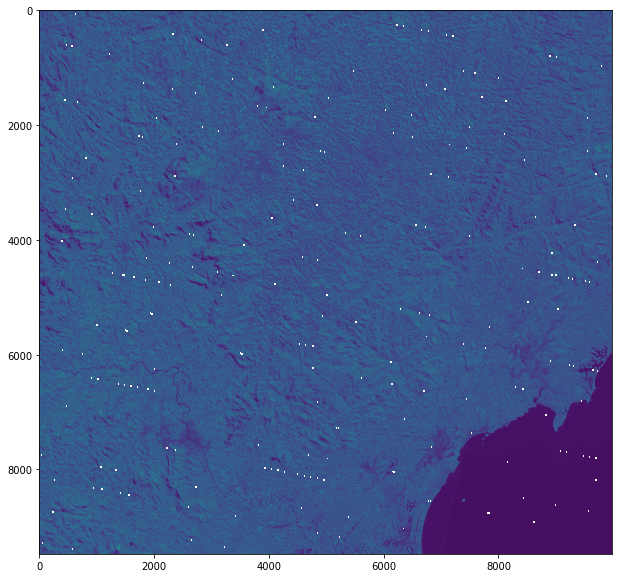

In [9]:
src_image_array[src_image_array==0] = np.nan
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image_array, ax=ax)
plt.show()

##Subseting an Image

To only access a particular part of the image, you can filter out with rows, columns, width and height of the picture. Let us say, we do not want the whole image but an image with 256 X 256 (width and height) cutting off at 7000 cols and 8000 rows.

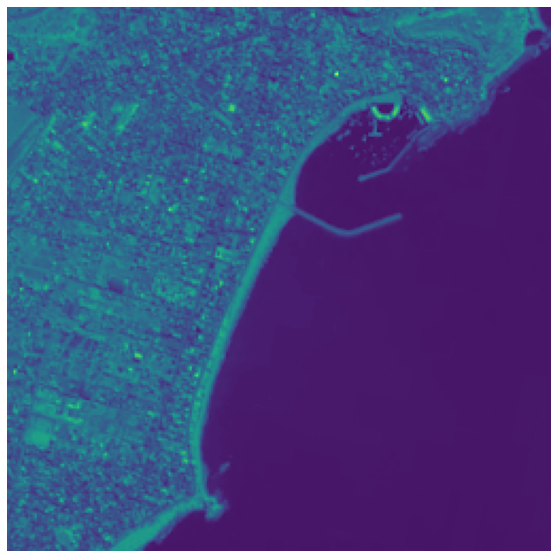

In [13]:
# Window(col_off, row_off, width, height)
window = rio.windows.Window(7000, 8000, 256, 256)
subset = sample_image.read(1, window=window)
fig, ax = plt.subplots(1, figsize=(12, 10))
show(subset, ax=ax)
ax.set_axis_off()
plt.show()

##Create a false color composite

First assign each band as a single image. Since we want to use the data for vegetation analysis, we'll use bands 4 (Near Infrared), 3(Red) and 2(Green) of the WPS CBERS 04A instrument

In [18]:
nir = rio.open('/content/drive/MyDrive/CBERS04A/CBERS_4A_WPM_20200501_196_139_L4_BAND4.tif')
red = rio.open('/content/drive/MyDrive/CBERS04A/CBERS_4A_WPM_20200501_196_139_L4_BAND3.tif')
green = rio.open('/content/drive/MyDrive/CBERS04A/CBERS_4A_WPM_20200501_196_139_L4_BAND2.tif')

We create a composite image by opening an empty image and populating it with the three bands we opened above

In [19]:
# Create pseudo color NIR-R-G (2,3,4) image
with rio.open('nrg.tiff','w',driver='Gtiff', width=red.width, height=red.height,count=3,crs=red.crs,transform=red.transform, dtype=red.dtypes[0]) as nrg:
  nrg.write(green.read(1),1)
  nrg.write(red.read(1),2)
  nrg.write(nir.read(1),3)
  nrg.close()

In [20]:
img = rio.open('/content/nrg.tiff')

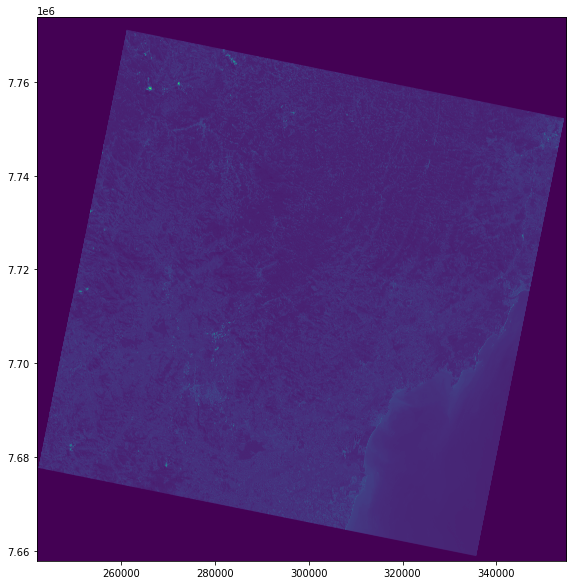

In [21]:
fig, ax = plt.subplots(1, figsize=(10, 10))
show(img, ax=ax)
plt.show()

Now the composite can be downloaded on the files section

In [22]:
img.meta

{'count': 3,
 'crs': CRS.from_epsg(32724),
 'driver': 'GTiff',
 'dtype': 'int16',
 'height': 14475,
 'nodata': None,
 'transform': Affine(8.0, 0.0, 242044.0,
       0.0, -8.0, 7773730.0),
 'width': 14096}

Getting Image 256x256 tiles

In [25]:
in_path = '/content/drive/MyDrive/CBERS04A/'
input_filename = 'sample_image.tif'

out_path = '/content/drive/MyDrive/CBERS04A/tiles/images/'
output_filename = 'tile_{}-{}.tif'

def get_tiles(ds, width=256, height=256):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform


with rio.open(os.path.join(in_path, input_filename)) as inds:
    tile_width, tile_height = 256, 256

    meta = inds.meta.copy()

    for window, transform in get_tiles(inds):
        print(window)
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))

Window(col_off=0, row_off=0, width=256, height=256)
Window(col_off=0, row_off=256, width=256, height=256)
Window(col_off=0, row_off=512, width=256, height=256)
Window(col_off=0, row_off=768, width=256, height=256)
Window(col_off=0, row_off=1024, width=256, height=256)
Window(col_off=0, row_off=1280, width=256, height=256)
Window(col_off=0, row_off=1536, width=256, height=256)
Window(col_off=0, row_off=1792, width=256, height=256)
Window(col_off=0, row_off=2048, width=256, height=256)
Window(col_off=0, row_off=2304, width=256, height=256)
Window(col_off=0, row_off=2560, width=256, height=256)
Window(col_off=0, row_off=2816, width=256, height=256)
Window(col_off=0, row_off=3072, width=256, height=256)
Window(col_off=0, row_off=3328, width=256, height=256)
Window(col_off=0, row_off=3584, width=256, height=256)
Window(col_off=0, row_off=3840, width=256, height=256)
Window(col_off=0, row_off=4096, width=256, height=256)
Window(col_off=0, row_off=4352, width=256, height=256)
Window(col_off=0

Getting Labels 256x256 tiles

In [27]:
in_path = '/content/drive/MyDrive/CBERS04A/'
input_filename = 'sample_label.tif'

out_path = '/content/drive/MyDrive/CBERS04A/tiles/labels/'
output_filename = 'tile_{}-{}.tif'

with rio.open(os.path.join(in_path, input_filename)) as inds:
    tile_width, tile_height = 256, 256

    meta = inds.meta.copy()

    for window, transform in get_tiles(inds):
        print(window)
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))

Window(col_off=0, row_off=0, width=256, height=256)
Window(col_off=0, row_off=256, width=256, height=256)
Window(col_off=0, row_off=512, width=256, height=256)
Window(col_off=0, row_off=768, width=256, height=256)
Window(col_off=0, row_off=1024, width=256, height=256)
Window(col_off=0, row_off=1280, width=256, height=256)
Window(col_off=0, row_off=1536, width=256, height=256)
Window(col_off=0, row_off=1792, width=256, height=256)
Window(col_off=0, row_off=2048, width=256, height=256)
Window(col_off=0, row_off=2304, width=256, height=256)
Window(col_off=0, row_off=2560, width=256, height=256)
Window(col_off=0, row_off=2816, width=256, height=256)
Window(col_off=0, row_off=3072, width=256, height=256)
Window(col_off=0, row_off=3328, width=256, height=256)
Window(col_off=0, row_off=3584, width=256, height=256)
Window(col_off=0, row_off=3840, width=256, height=256)
Window(col_off=0, row_off=4096, width=256, height=256)
Window(col_off=0, row_off=4352, width=256, height=256)
Window(col_off=0

Placing tiles on a .tar file

In [36]:
import tarfile
import os.path

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
make_tarfile('cbers_test.tgz','/content/drive/MyDrive/CBERS04A/tiles/')

In [35]:
import shutil
shutil.make_archive('cbers_test', 'zip', '/content/drive/MyDrive/CBERS04A/tiles/')

'/content/cbers_zip.zip'

In [28]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 6.9MB/s 
     |████████████████████████████████| 1.2MB 15.1MB/s 
     |████████████████████████████████| 194kB 28.7MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
Mounted at /content/gdrive


In [32]:
path = /content/drive/MyDrive/CBERS04A/tiles/
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

SyntaxError: ignored

In [33]:
path = untar_data(URLs.CAMVID_TINY)
print(URLs.CAMVID_TINY)

https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [30]:

dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

#END